<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Text Summarization Using Encoder And Decoder</h1>
</div>


<div style="background-color: #f0f0f0; padding: 20px; border-radius: 10px;">
  <h3 style="color: #333333; text-align: center; font-weight: bold;">What Is Text Summarization?</h3>
  <p style="color: #666666; text-align: justify;">Text summarization is the process of condensing a piece of text while retaining its key information and main ideas. It's commonly used in various applications such as news articles, research papers, and legal documents to provide a concise overview of the content.</p>
  <p style="color: #666666; text-align: justify;">Using an encoder-decoder model with multiple layers of LSTM (Long Short-Term Memory) cells with attention mechanism is a popular approach for text summarization.</p>
  <div style="background-color: #4CAF50; color: #ffffff; padding: 10px; border-radius: 5px; text-align: center;">
    <p style="margin: 0;">In This Notebook I Will Use Encoder And Decoder Model To Build A Text Summarization Model</p>
  </div>
</div>


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Import Dependencis</h1>
</div>


In [4]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

2024-08-15 12:38:15.139488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 12:38:15.139586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 12:38:15.299295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="background-color: #f0f0f0; padding: 20px; border-radius: 10px;">
  <h3 style="color: #333333; text-align: center; font-weight: bold;">About Dataset</h3>
  <p style="color: #666666; text-align: justify;">To build a good text summarization model, a large dataset is essential. Therefore, I have combined two CSV files from Kaggle into one CSV file.</p>
  <p style="color: #666666; text-align: justify;">If you wish to use these CSV files for your problem, I will mention them at the beginning of this notebook.</p>
  <div style="background-color: #4CAF50; color: #ffffff; padding: 10px; border-radius: 5px; text-align: center;">
    <p style="margin: 0;">So let's dive in and begin the journey!</p>
  </div>
</div>


In [5]:
import pandas as pd

# Try different encodings
encodings_to_try = ['utf-8', 'latin1', 'ISO-8859-1', 'utf-16']

for encoding in encodings_to_try:
    try:
        df1 = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding=encoding)
        df2 = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding=encoding)
        print(f"Successfully read CSV files using encoding: {encoding}")
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        print(f"Failed to read CSV files using encoding: {encoding}")

Failed to read CSV files using encoding: utf-8
Successfully read CSV files using encoding: latin1


In [6]:
df1.head(1)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...


In [7]:
df2.head(1)

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."


In [8]:
print(df1.columns)
print(df2.columns)

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')
Index(['headlines', 'text'], dtype='object')


In [9]:
import pandas as pd

# Combine 'text' columns from df1 and df2
syntext = pd.concat([df1['text'], df2['text']], ignore_index=True)

# Combine 'headlines' columns from df1 and df2
summary = pd.concat([df1['headlines'], df2['headlines']], ignore_index=True)

# Create a new DataFrame with 'syntext' and 'Summary' columns
data = pd.DataFrame({'text': syntext, 'summary': summary})



In [10]:
data.head(1)

,text,summary
0,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,Daman & Diu revokes mandatory Rakshabandhan in offices order


In [11]:
print('Content: ', data['text'][1])
print('\n')
print('summary: ', data['summary'][1])

Content:  Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoying vacation[s]," the user commented. Malaika responded, "You certainly got to get your damn facts right before spewing sh*t on me...when you know nothing about me."


summary:  Malaika slams user who trolled her for 'divorcing rich man' 


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Function For Cleaning Data</h1>
</div>


In [12]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=f4d300fdcf5e2a42e009e25ab9751ed8baacb34774076fd4be7383fa6b079351
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [13]:
#Removes non-alphabetic characters:
def text_cleaner(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Cleaning Data And Displaying</h1>
</div>


In [14]:
clean_text = text_cleaner(data['text'])
clean_summary = text_cleaner(data['summary'])

In [15]:
from time import time 
import spacy
from tqdm.notebook import tqdm

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # Load English model
t = time()
text = [str(doc) for doc in tqdm(nlp.pipe(clean_text, batch_size=5000, n_process=-1))]

print('Time to Clean up Data: {} Mins'.format(round((time() - t) / 60, 2)))


0it [00:00, ?it/s]


KeyboardInterrupt



<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Cleaning Summaries Data and Add Start and End Tag</h1>
</div>


In [16]:
t = time()
summary = ['_START ' + str(doc) + ' _END_' for doc in tqdm(nlp.pipe(clean_summary, batch_size=5000, n_process=-1))]
print('Time to clean up summary data: {} Mins'.format(round((time() - t)/ 60, 2)))

0it [00:00, ?it/s]


KeyboardInterrupt



In [ ]:
data1 = pd.DataFrame({
    'clean_txt': cleaned_text,
    'clean_summary': cleaned_summaries
})

In [ ]:
text[1]

In [ ]:
summary[1]

In [ ]:
data['text'] = pd.Series(text)
data['summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Define word Between 0-15 Words for Summary And 0-100 Words For Text</h1>
</div>


In [17]:
max_text_len = 100
max_summary_len = 15

In [18]:
cleaned_text = np.array(data['text'])
cleaned_summary = np.array(data['summary'])

short_text = []
short_summary = []

for i in tqdm(range(len(cleaned_text))):
    # Check if the element is not NaN (assuming NaNs are represented as float)
    if not isinstance(cleaned_summary[i], float) and not isinstance(cleaned_text[i], float):
        if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
            short_text.append(str(cleaned_text[i]))  # Convert to string before appending
            short_summary.append(str(cleaned_summary[i]))  # Convert to string before appending

post_data = pd.DataFrame({
    'text': short_text,
    'summary': short_summary
})

  0%|          | 0/102915 [00:00<?, ?it/s]

In [19]:
post_data.head(3)

,text,summary
0,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,Daman & Diu revokes mandatory Rakshabandhan in offices order
1,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...",Malaika slams user who trolled her for 'divorcing rich man'
2,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...",'Virgin' now corrected to 'Unmarried' in IGIMS' form


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Add Sostok And Eostok</h1>
</div>


In [20]:
post_data['summary'] = post_data['summary'].apply(lambda x : 'sostok ' + x + ' eostok')

In [21]:
post_data.head(1)

,text,summary
0,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,sostok Daman & Diu revokes mandatory Rakshabandhan in offices order eostok


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Seq2Seq Model Building</h1>
</div>


In [22]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(np.array(post_data['text']), np.array(post_data['summary']), test_size=0.1, random_state=0, shuffle=True)

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Tokenize The Text</h1>
</div>


In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing .sequence import pad_sequences

# prepare a tokenizer for review on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(xtrain))

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Rare Word Analysis For Xi.e 'text'</h1>
</div>

1. tot_cnt gives the size of vocabulary(which means unique word in the text)
2. cnt gives the number of rare words whose count falls below thresold
3. tot_cnt - cnt gives the top most common words

In [24]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.11090094165056
Total Coverage of rare words: 1.6071110505509574


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Prepare a Tokenizer For Text On Trainig Data</h1>
</div>


In [25]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(xtrain))

# Convert text sequences to interger sequences
x_train_seq = x_tokenizer.texts_to_sequences(xtrain)
x_test_seq = x_tokenizer.texts_to_sequences(xtest)

# Padding zero upto maximum length
xtrain = pad_sequences(x_train_seq, maxlen = max_text_len, padding='post')
xtest = pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

# size of vocabulary
x_voc = x_tokenizer.num_words + 1
print('Size of vocabulary in x = {}'.format(x_voc))

Size of vocabulary in x = 36858


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Rare Word Analysis For Summary</h1>
</div>

In [26]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(ytrain))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.97806296184763
Total Coverage of rare words: 3.6104174882628035


In [27]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(ytrain))

# converage text sequences into integer sequences
y_trian_seq = y_tokenizer.texts_to_sequences(ytrain)
y_test_seq = y_tokenizer.texts_to_sequences(ytest)

# padding zero upto maximum length
ytrain = pad_sequences(y_trian_seq, maxlen=max_summary_len, padding='post')
ytest = pad_sequences(y_test_seq, maxlen=max_summary_len, padding = 'post')

# size of vocabulary 
y_voc = y_tokenizer.num_words + 1
print('Size of Vocabulary in Y = {}'.format(y_voc))

Size of Vocabulary in Y = 15983


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Remove Summary which has only START and END tag</h1>
</div>

In [28]:
ind=[]
for i in range(len(ytest)):
    cnt=0
    for j in ytest[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

ytrian=np.delete(ytest,ind, axis=0)
xtrian=np.delete(xtest,ind, axis=0)

In [29]:
xtrain.shape

(92613, 100)

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Building Model</h1>
</div>

In [30]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))


Size of vocabulary from the w2v model = 36858


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Encoder Architecture</h1>
</div>

In [45]:
K.clear_session()
laten_dim = 300
embedding_dim = 200

encoder_inputs  = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder lstm 1
encoder_lstm1  = LSTM(laten_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder lstm 2
encoder_lstm2 = LSTM(laten_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder lstem 3
encoder_lstm3 = LSTM(laten_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Set Up the Decoder</h1>
</div>

In [46]:
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(laten_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# dense layer
decoder_dense = TimeDistributed(Dense(y_voc,activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 200)             7371600   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 100, 300),           601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

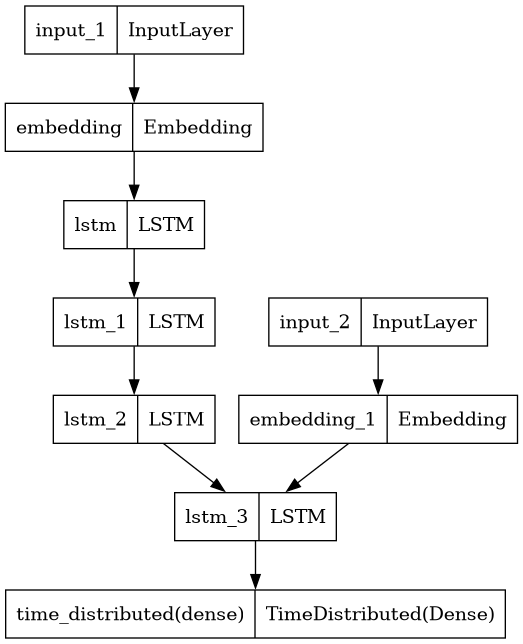

In [47]:
from keras.utils import plot_model
plot_model(model)

In [48]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

In [49]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Train The Model</h1>
</div>

In [50]:
history=model.fit([xtrain,ytrain[:,:-1]], ytrain.reshape(ytrain.shape[0],ytrain.shape[1], 1)[:,1:] ,epochs=2,callbacks=[es],batch_size=128, validation_data=([xtest,ytest[:,:-1]], ytest.reshape(ytest.shape[0],ytest.shape[1], 1)[:,1:]))

Epoch 1/2
724/724 [==============================] - 686s 931ms/step - loss: 5.3496 - val_loss: 4.9255
Epoch 2/2
724/724 [==============================] - 650s 897ms/step - loss: 4.8014 - val_loss: 4.5972


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Build The Dictonary to Convert Index to Word</h1>
</div>


In [1]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

NameError: name 'y_tokenizer' is not defined

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Encode the Input to Get the Feature</h1>
</div>


In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Set Up Decoder</h1>
</div>


In [ ]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Function For Implementation Process</h1>
</div>


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Function For Integer Seq To Word Seq</h1>
</div>


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Run The Model Over The Data</h1>
</div>


In [ ]:
for i in range(0,5):
    print("Review:",seq2text(xtrain[i]))
    print("Original summary:",seq2summary(ytrain[i]))
    print("Predicted summary:",decode_sequence(xtrain[i].reshape(1,max_text_len)))
    print("\n")

<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Let's Make  a System to generate Summrization</h1>
</div>


In [ ]:
with open('decode_sequence1.pkl', 'rb') as handle:
    decode_sequence1 = pickle.load(handle)
    
def preprocess_input_content(input_content):
    cleaned_input = list(text_cleaner([input_content]))[0]
    input_sequence = x_tokenizer.texts_to_sequences([cleaned_input])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=max_text_len, padding='post')
    return padded_input_sequence
def generate_summary(input_content):
    preprocessed_input = preprocess_input_content(input_content)
    summary = decode_sequence1(preprocessed_input)
    return summary
# Example usage in your app
input_content = "This is the input text that needs to be summarized."
summary = generate_summary(input_content)
print("Generated Summary:", summary)


<div style="background-color: #8b0000; padding: 10px; text-align: center;">
  <h1 style="color: #ffffff; text-shadow: 0 0 10px #ff6666;">Saving Model</h1>
</div>


In [ ]:
# Save model architecture and weights
model.save('text_summarization_model.h5')

# Save tokenizers
import pickle
with open('x_tokenizer.pkl', 'wb') as handle:
    pickle.dump(x_tokenizer, handle)
with open('y_tokenizer.pkl', 'wb') as handle:
    pickle.dump(y_tokenizer, handle)
with open('decode_sequence1.pkl', 'wb') as handle:
    pickle.dump(decode_sequence, handle)